# SNILC Syllables

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import product
from functools import partial
from copy import copy

from dynamical_systems import SNILC, airflow
from numerical_syllables import *
from aux_functions_manual import *

We consider the following system of equations
$$
\begin{cases}
\dot{r} \propto (\mu - r^2)r, \\
\dot{\phi} \propto \omega - \cos(\phi)
\end{cases}
$$

The bifurcation (from having a stable node in the limit cycle to relaxation oscillations) occurs when $\omega$ goes from positive, less than 1 to more than 1.


## Integration parameters

In [3]:
t0 = 0                  # Initial trajectory time
tf = 10                  # Final trajectory time 

# Use subsample=1 or 8 for testing (fast, low resolution), and 40 for high resolution.
# subsample = 1
# subsample = 8
subsample = 40

step = 1/(subsample * 44150.0)      # timestep

save = True if subsample == 40 else False

In [4]:
trange = np.arange(t0,tf,step)

## Equation parameters

In [5]:
mu = 1            
y0 = (1,0)

# type = "slow"
type = "fast"

convolution = True # If true, multiply the parameter times the solution

In [6]:
def w_function(t, height=2.71*1e6/6, lambda1=3, lambda2=3, T1=7, T2=3):
    # Change the height of the function to move the spectrum
    return height * airflow(t, lambda1, lambda2, T1, T2) 

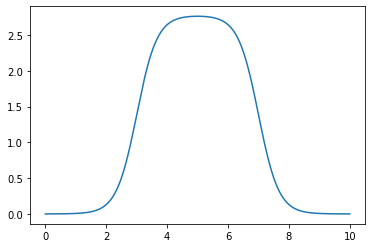

In [7]:
plt.plot(trange,[w_function(t) for t in trange])

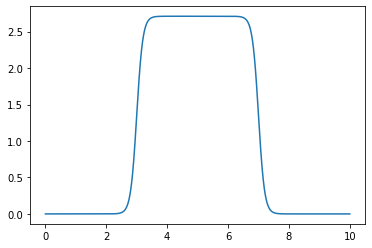

In [8]:
if type == "fast":
    w_function = partial(w_function, height=0.638*1e18, lambda1=10, lambda2=10) # fast
    plt.plot(trange,[w_function(t) for t in trange])

## Solution and plots

In [9]:
sol = RK45_SNILC(partial(SNILC, prop=5000), y0, t0, tf, step, mu, w_function)

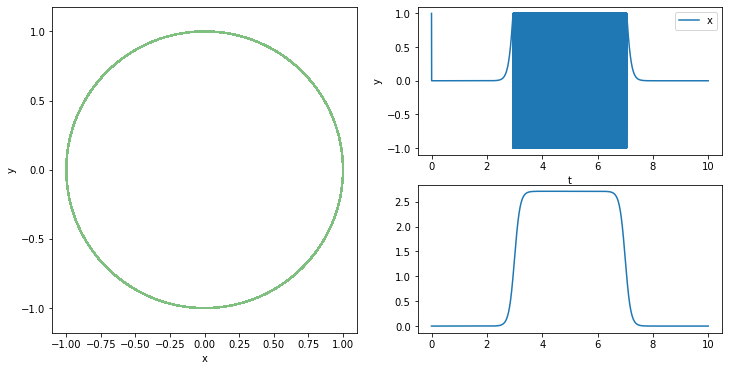

In [10]:
fig = plt.figure(figsize=(12, 6))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(2,2,2)
ax2 = plt.subplot(2,2,4)
ax = [ax0, ax1, ax2]

ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax0.axis('equal')

ax1.set_xlabel('t')
ax1.set_ylabel('y')
#ax1.set_ylabel('x,y')

ax0.plot(sol.y[0] * np.cos(sol.y[1]), sol.y[0] * np.sin(sol.y[1]), alpha=0.5, color="green")
ax1.plot(sol.t, sol.y[0] * np.cos(sol.y[1]), label="x")
#ax1.plot(sol.t, sol.y[0] * np.sin(sol.y[1]), label="y")
#ax1.plot(sol.t, sol.y[1], label="y")

ax2.plot(sol.t, [w_function(t) for t in sol.t])

ax1.legend()

In [11]:
tsol = sol.t[0::subsample]
rhosol = sol.y[0][0::subsample]
phisol = sol.y[1][0::subsample]
xsol = rhosol * np.cos(phisol)
ysol = rhosol * np.sin(phisol)

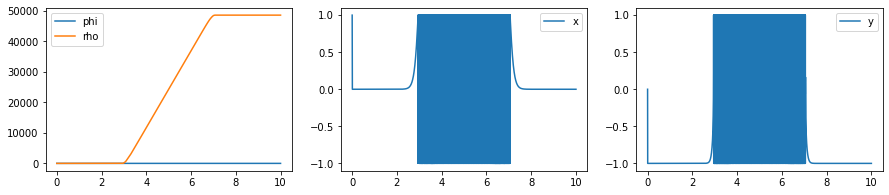

In [12]:
fig = plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(tsol, rhosol, label="phi")
plt.plot(tsol, phisol, label="rho")
plt.legend()
plt.subplot(1,3,2)
plt.plot(tsol, xsol, label="x")
plt.legend()
plt.subplot(1,3,3)
plt.plot(tsol, ysol, label="y")
plt.legend()

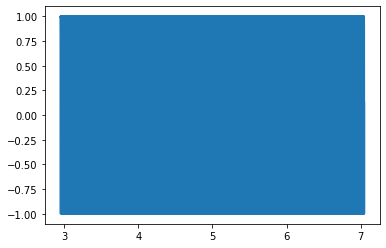

In [13]:
start = np.argmax(xsol[100:] > 0.99) + 100
end = np.argmax(xsol[::-1] < -0.99)
window = [start-10,10-end]
xwindow = xsol[window[0]:window[1]]
twindow = tsol[window[0]:window[1]]
plt.plot(twindow, xwindow, label="x")

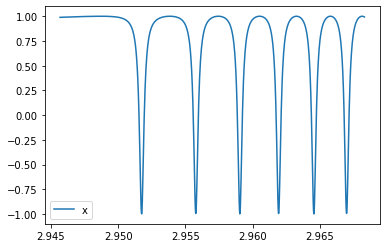

In [14]:
plt.plot(twindow[0:1000], xwindow[0:1000], label="x")
plt.legend()

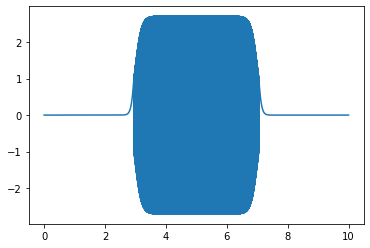

In [15]:
if convolution:
    gating = [w_function(t) for t in tsol]
    xsol = np.multiply(gating, xsol)
    plt.plot(tsol, xsol)

In [16]:
if save:
    print("Saving solution")
    import pickle        
    if type == "fast":
        with open(f"Output/SNILC_xsol.pkl", 'wb') as f:
            pickle.dump({"tsol":tsol, "xsol":xsol}, f)
    elif type == "slow":
        with open(f"Output/SNILC_slow_xsol.pkl", 'wb') as f:
            pickle.dump({"tsol":tsol, "xsol":xsol}, f)
else:
    print("Solution not saved")

Saving solution


## Spectrum

In [17]:
from scipy.fft import fft, fftfreq, fftshift

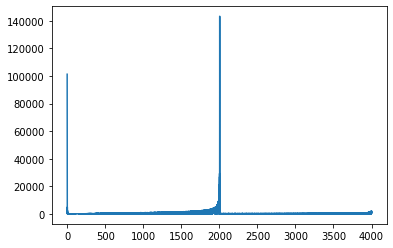

In [18]:
xf = fftfreq(len(xsol), step * subsample)[:len(xsol)//2]
yf = fft(xsol)
spectrum = np.abs(yf)[:len(xsol)//2]

plt.plot(xf[:40000], spectrum[:40000])

## Audio

In [16]:
from IPython.display import Audio
Audio(xsol, rate=int(1/(subsample*step)))

In [17]:
from scipy.io.wavfile import write

rate = int(1/(subsample*step))
scaled = np.int16(xsol / np.max(np.abs(xsol)) * 32767)
#write('Output/SNILC.wav', rate, scaled)